## Visual Comparison

(256, 256)
(256, 256)


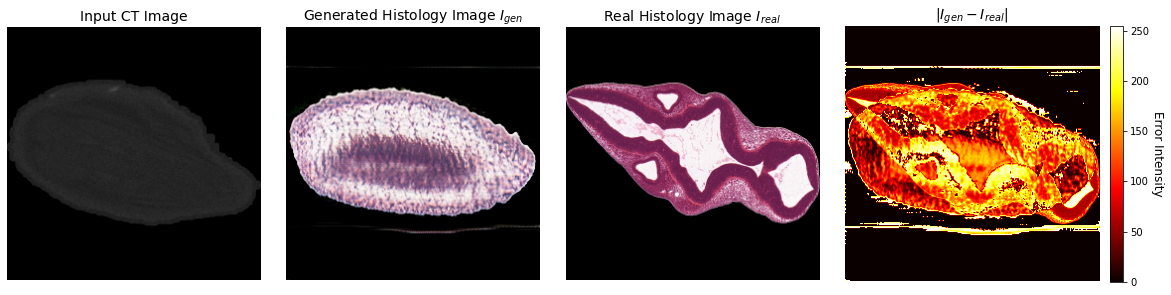

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2

# Define the paths to the images 
input_ct_image_path = './pairs/pair1_C1_50kV_1279.png'    
synthesized_hist_image_path = './pairs/pair1_fake_C1_50kV_1279_fake.png'  
real_hist_image_path = './pairs/pair1_hist_TS17_s20r01s07.jpg'

# Load the images using OpenCV
input_ct_image = cv2.imread(input_ct_image_path)
synthesized_hist_image = cv2.imread(synthesized_hist_image_path)
real_hist_image = cv2.imread(real_hist_image_path)

# Resize images to the smallest image dimensions
min_height = min(input_ct_image.shape[0], synthesized_hist_image.shape[0], real_hist_image.shape[0])
min_width = min(input_ct_image.shape[1], synthesized_hist_image.shape[1], real_hist_image.shape[1])

input_ct_image_resized = cv2.resize(input_ct_image, (min_width, min_height))
synthesized_hist_image_resized = cv2.resize(synthesized_hist_image, (min_width, min_height))
real_hist_image_resized = cv2.resize(real_hist_image, (min_width, min_height))

# Convert images to grayscale for error computation
synthesized_hist_gray = cv2.cvtColor(synthesized_hist_image_resized, cv2.COLOR_BGR2GRAY)
real_hist_gray = cv2.cvtColor(real_hist_image_resized, cv2.COLOR_BGR2GRAY)

# Compute the absolute error between real and synthesized histology images
absolute_error_array = np.abs(real_hist_gray - synthesized_hist_gray)

# Create the plot with GridSpec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1.1], wspace=0.1)

# Plot the input CT image
ax0 = plt.subplot(gs[0])
ax0.imshow(cv2.cvtColor(input_ct_image_resized, cv2.COLOR_BGR2RGB))
ax0.set_title('Input CT Image', fontsize=14)
ax0.axis('off')

# Plot the synthesized histology image
ax1 = plt.subplot(gs[1])
ax1.imshow(cv2.cvtColor(synthesized_hist_image_resized, cv2.COLOR_BGR2RGB))
ax1.set_title('Generated Histology Image $I_{gen}$', fontsize=14)
ax1.axis('off')

# Plot the real histology image
ax2 = plt.subplot(gs[2])
ax2.imshow(cv2.cvtColor(real_hist_image_resized, cv2.COLOR_BGR2RGB))
ax2.set_title('Real Histology Image $I_{real}$', fontsize=14)
ax2.axis('off')

# Plot the absolute error image with adjusted colormap and colorbar
ax3 = plt.subplot(gs[3])
cax = ax3.imshow(absolute_error_array, cmap='hot', vmin=0, vmax=absolute_error_array.max())
ax3.set_title('$|I_{gen} - I_{real}|$', fontsize=14)
ax3.axis('off')

# Add a color bar with better visibility settings
cbar = fig.colorbar(cax, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)  # Adjust tick label size for better visibility
cbar.set_label('Error Intensity', rotation=270, labelpad=15, fontsize=12)

# Show the plot
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

## Metric Evaluation

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from image_similarity_measures.quality_metrics import psnr, ssim

# Define paths
image_folder = './pairs'

# Define prefixes
hist_prefix = 'hist'
fake_prefix = 'fake'

# Lists to store results
results = []

# Function to compute similarity metrics
def compute_similarity_metrics(img1, img2):
    mae = np.mean(np.abs(img1 - img2))
    rmse = np.sqrt(np.mean((img1 - img2) ** 2))
    psnr_value = psnr(img1, img2)
    ssim_value = ssim(img1, img2)
    return mae, rmse, psnr_value, ssim_value

# Function to resize images to the smaller size
def resize_to_smaller(img1, img2):
    if img1.shape[:2] != img2.shape[:2]:
        smaller_size = min(img1.shape[:2], img2.shape[:2])
        img1 = cv2.resize(img1, (smaller_size[1], smaller_size[0]))
        img2 = cv2.resize(img2, (smaller_size[1], smaller_size[0]))
    return img1, img2

# Get a list of all files in the folder
all_files = os.listdir(image_folder)

# Extract unique pairs
pair_count = set(file.split("_")[0] for file in all_files)

# Iterate over all unique pairs
for pair in pair_count:
    # Find corresponding hist and fake images
    hist_image_name = None
    fake_image_name = None
    for file_name in all_files:
        if file_name.startswith(pair) and hist_prefix in file_name:
            hist_image_name = file_name
        elif file_name.startswith(pair) and fake_prefix in file_name:
            fake_image_name = file_name

    if hist_image_name and fake_image_name:
        hist_image_path = os.path.join(image_folder, hist_image_name)
        fake_image_path = os.path.join(image_folder, fake_image_name)

        # Ensure the fake image exists
        if os.path.exists(fake_image_path):
            # Read the images
            hist_image = cv2.imread(hist_image_path)
            fake_image = cv2.imread(fake_image_path)

            # Resize images to the smaller size
            hist_image, fake_image = resize_to_smaller(hist_image, fake_image)

            # Compute similarity metrics
            mae, rmse, psnr_value, ssim_value = compute_similarity_metrics(hist_image, fake_image)
            results.append([pair, round(mae, 3), round(rmse, 3), round(psnr_value, 3), round(ssim_value, 3)])
        else:
            print(f"Fake image {fake_image_name} not found.")
    else:
        print(f"Pair {pair} does not have both hist and fake images.")

# Create a DataFrame and save to CSV
df = pd.DataFrame(results, columns=['Image', 'MAE', 'RMSE', 'PSNR', 'SSIM'])
df.to_csv('image_similarity_metrics.csv', index=False)

print("Metrics calculation complete. Results saved to 'image_similarity_metrics.csv'.")


Metrics calculation complete. Results saved to 'image_similarity_metrics.csv'.


## metrics plots

Inspiration from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/1096

New log with starting log date 2024-07-10 15:16:40


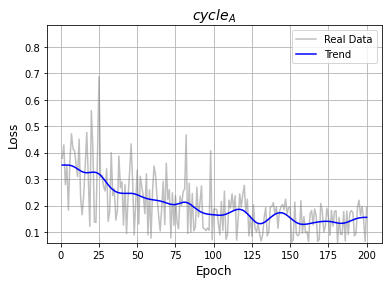

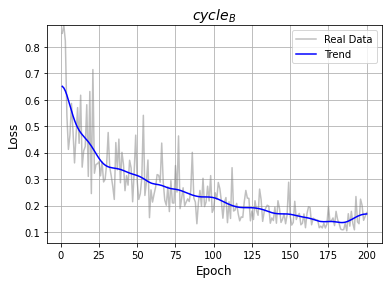

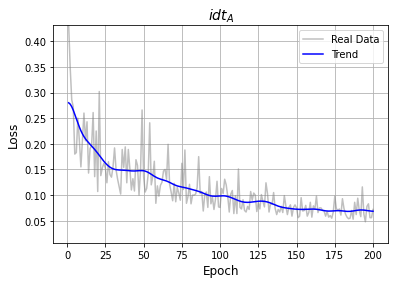

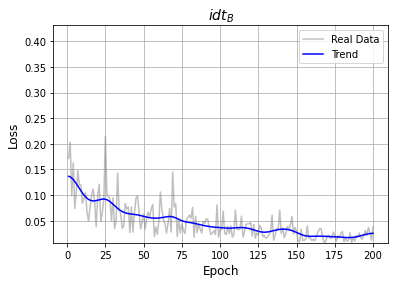

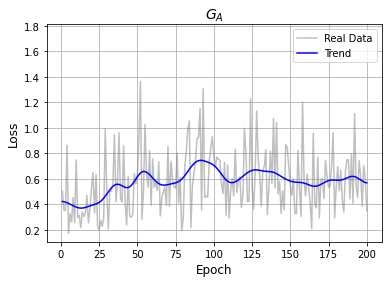

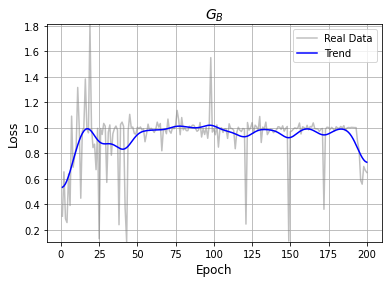

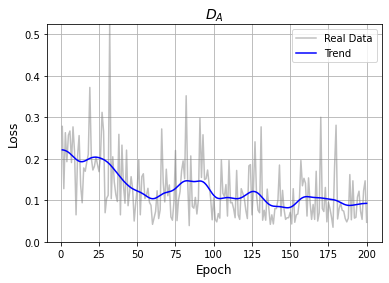

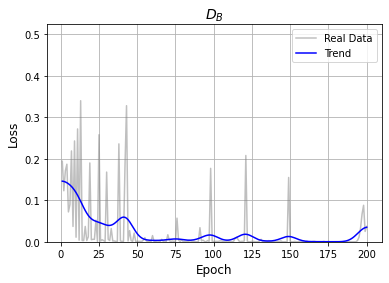

In [13]:
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime
from scipy.ndimage import gaussian_filter1d

# Function to parse the date from the log line
def parse_date(logline):
    return datetime.strptime(logline[32:56], '%a %b %d %H:%M:%S %Y')

# Function to read the log file and extract data
def read_log(filepath, run="final"):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        run_nr = 0
        all_data = []
        current_logdate = ""
        
        for ix, line in enumerate(lines):
            # Identify the start of a new training run
            if "Training Loss" in line:
                run_nr += 1
                current_logdate = parse_date(line).isoformat().replace("T", " ")
                print(f"New log with starting log date {current_logdate}")
            else:
                # Clean and parse the line
                line = re.sub('[^0-9a-zA-Z ._]+', '', line)
                line_arr = line.split()
                line_data = {k: v for k, v in zip(line_arr[0::2], line_arr[1::2])}
                line_data.update({"run": run_nr, "run_date": current_logdate})
                all_data.append(line_data)
        
        df = pd.DataFrame(all_data)
        
        # Convert specific columns to appropriate data types
        df['epoch'] = df['epoch'].astype(int)
        df['iters'] = df['iters'].astype(int)
        
        for col in ["cycle_A", "cycle_B", "G_A", "G_B", "idt_A", "idt_B", "D_A", "D_B"]:
            df[col] = df[col].astype(float)
        
        # Filter data based on the specified run
        if isinstance(run, int):
            df = df[df["run"] == run]
        elif run == "final":
            df = df[df["run"] == run_nr]
        
        # Group by epoch and get the last entry for each epoch
        df = df.groupby(by="epoch", group_keys=False).last().reset_index().sort_values(by="epoch")
        return df

# Function to plot the metrics
def plot_metrics(df):
    metric_groups = {
        "cycle": ["cycle_A", "cycle_B"],
        "idt": ["idt_A", "idt_B"],
        "G": ["G_A", "G_B"],
        "D": ["D_A", "D_B"]
    }
    
    y_limits = {}
    
    # Determine y-axis limits for each group
    for group_name, metrics in metric_groups.items():
        min_val = min(df[metrics].min())
        max_val = max(df[metrics].max())
        y_limits[group_name] = (min_val, max_val)
    
    # Plot each metric group
    for group_name, metrics in metric_groups.items():
        for col in metrics:
            plt.figure()
            # Plot the real data in grey
            plt.plot(df["epoch"], df[col], color='grey', alpha=0.5, label='Real Data')
            
            # Apply Gaussian smoothing to create a trend line
            smoothed_data = gaussian_filter1d(df[col], sigma=5)
            plt.plot(df["epoch"], smoothed_data, label=f'Trend', color='blue')
            
            plt.title(f'${col}$', fontsize=14)
            plt.xlabel("Epoch", fontsize=12)
            plt.ylabel("Loss", fontsize=12)
            plt.ylim(y_limits[group_name])
            plt.legend()
            plt.grid(True)
            plt.show()

# Read the log file and plot the metrics
log_file_path = '../checkpoints/quantity_test_1000/loss_log.txt'  # Update this with the path to your log file
df = read_log(log_file_path, run="final")
plot_metrics(df)
